In [39]:
import numpy as np
from scipy.linalg import sqrtm 
from scipy.special import softmax
import torch
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
from IPython.display import HTML

In [40]:
g = nx.karate_club_graph()

In [41]:
def normalize_adj_matrix(A):
    I = np.identity(A.shape[0])
    A = A + I
    
    D_mod = np.zeros_like(A)
    np.fill_diagonal(D_mod, A.sum(axis = 1))
    D_mod_inv_root = np.linalg.inv(sqrtm(D_mod))
    
    return D_mod_inv_root @ A @ D_mod_inv_root

In [42]:
def xent(pred, labels):
    return -np.log(pred)[np.arange(pred.shape[0]), np.argmax(labels, axis=1)]

In [43]:
class Optimizer:
    def __init__(self, lr = 0.05):
        self.lr = lr
        self.grads = None

In [44]:
class GCNLayer:
    def __init__(self, Fi, Fj, name):
        self.Fi = Fi
        self.Fj = Fj
        self.name = name
        self.W = np.random.normal(loc=0, scale=1, size=(Fi, Fj))
        
    
    def gcn_forward(self, A, X):
        self.X = A @ X
        self.A = A
        self.message = A @ X @ self.W
        self.next_layer_input = np.tanh(self.message)
        return self.next_layer_input #n, Fj
    
    def gcn_backprop(self, optimizer):
        tanh_derivative = 1 - np.square(self.next_layer_input) #n, Fj
        temp = np.multiply(optimizer.grads, tanh_derivative) # n, out * in, out.T = n, in
        optimizer.grads = self.A @ temp @ self.W.T #n, n * n, in * in, out = n, out
        dW = self.X.T @ temp
        self.W -= dW * optimizer.lr
        
        return dW
    

In [45]:
X = np.eye(g.number_of_nodes())

A = nx.to_numpy_matrix(g)

A_hat = normalize_adj_matrix(A)

In [46]:
communities = greedy_modularity_communities(g)
colors = np.zeros(g.number_of_nodes())
for i, com in enumerate(communities):
    colors[list(com)] = i

n_classes = np.unique(colors).shape[0]
labels = np.eye(n_classes)[colors.astype(int)]

In [47]:
t = torch.tensor([labels])
t = t[0]

In [48]:
train_nodes = np.array([0, 1, 8])
test_nodes = np.array([i for i in range(labels.shape[0]) if i not in train_nodes])

In [49]:
test_nodes

array([ 2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [50]:
class GCNNetwork():
    def __init__(self, n_inputs, n_outputs, n_layers, hidden_sizes):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.hidden_sizes = hidden_sizes
        

        self.layers = list()
        # Input layer
        gcn_in = GCNLayer(n_inputs, hidden_sizes[0], name='in')
        self.layers.append(gcn_in)
        
        
        # Hidden layers
        for layer in range(n_layers):
            gcn = GCNLayer(self.layers[-1].W.shape[1], hidden_sizes[layer], name=f'h{layer}')
            self.layers.append(gcn)
            
        # Output layer
        linear_layer = torch.nn.Linear(hidden_sizes[-1], n_outputs, bias = False)
        softmax = torch.nn.Softmax(dim=1)
        self.layers.append(linear_layer)
        self.layers.append(softmax)
        
        
    def __repr__(self):
        return '\n'.join([str(l) for l in self.layers])
    
    def embedding(self, A, X):
        # Loop through all GCN layers
        H = X
        for layer in self.layers[:-2]:
            H = layer.gcn_forward(A, H)
        return np.asarray(H)
    
    def forward(self, A, X):
        # GCN layers
        H = self.embedding(A, X)
        
        # Softmax
        H = H.astype(np.float32)
        H_new = torch.from_numpy(H) 
        linear_out = torch.matmul(H_new, self.layers[-2].weight.T)
        
        y_pred = self.layers[-1](linear_out)
        
        loss = torch.sub(y_pred, t)
        
        for i in test_nodes.tolist():
            loss[i] = 0
        
        grads = torch.matmul(loss.double(), self.layers[-2].weight.double())

        dW = loss.T.detach().numpy() @ H
        new_weights = self.layers[-2].weight - torch.from_numpy(dW.astype(np.float32)) * 0.05
        
        self.layers[-2].weight.data = new_weights

        return grads.detach().numpy(), y_pred.detach().numpy()

In [51]:
gcn_model = GCNNetwork(
    n_inputs=g.number_of_nodes(), 
    n_outputs=n_classes, 
    n_layers=2,
    hidden_sizes=[16, 2]
)
gcn_model

Linear(in_features=2, out_features=3, bias=False)
Softmax(dim=1)

In [52]:
test_nodes

array([ 2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [53]:
opt2 = Optimizer(lr = 0.05)

In [54]:
embeds = list()
accs = list()
train_losses = list()
test_losses = list()

loss_min = 1e6
es_iters = 0
es_steps = 50

for epoch in range(10000):
    
    grads, y_pred = gcn_model.forward(A_hat, X)
    opt2.grads = grads

    for layer in reversed(gcn_model.layers[:-2]):
        layer.gcn_backprop(opt2)
        
    embeds.append(gcn_model.embedding(A_hat, X))

    # Accuracy for non-training nodes
    acc = (np.argmax(y_pred, axis=1) == np.argmax(labels, axis=1))[
        [i for i in range(labels.shape[0]) if i not in train_nodes]
    ]
    accs.append(acc.mean())
    loss = xent(y_pred, labels)
    loss_train = loss[train_nodes].mean()
    loss_test = loss[test_nodes].mean()
    
    train_losses.append(loss_train)
    test_losses.append(loss_test)
    
    if loss_test < loss_min:
        loss_min = loss_test
        es_iters = 0
    else:
        es_iters += 1
        
    if es_iters > es_steps:
        print("Early stopping!")
        break
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch+1}, Train Loss: {loss_train:.3f}, Test Loss: {loss_test:.3f}")
        
train_losses = np.array(train_losses)
test_losses = np.array(test_losses)

Epoch: 1, Train Loss: 1.123, Test Loss: 1.156
Epoch: 101, Train Loss: 0.845, Test Loss: 0.911
Epoch: 201, Train Loss: 0.364, Test Loss: 0.499
Epoch: 301, Train Loss: 0.150, Test Loss: 0.470
Epoch: 401, Train Loss: 0.042, Test Loss: 0.334
Epoch: 501, Train Loss: 0.023, Test Loss: 0.284
Epoch: 601, Train Loss: 0.016, Test Loss: 0.259
Epoch: 701, Train Loss: 0.012, Test Loss: 0.244
Epoch: 801, Train Loss: 0.010, Test Loss: 0.233
Epoch: 901, Train Loss: 0.008, Test Loss: 0.226
Epoch: 1001, Train Loss: 0.007, Test Loss: 0.220
Epoch: 1101, Train Loss: 0.007, Test Loss: 0.216
Epoch: 1201, Train Loss: 0.006, Test Loss: 0.213
Epoch: 1301, Train Loss: 0.005, Test Loss: 0.210
Epoch: 1401, Train Loss: 0.005, Test Loss: 0.208
Epoch: 1501, Train Loss: 0.005, Test Loss: 0.206
Epoch: 1601, Train Loss: 0.004, Test Loss: 0.205
Epoch: 1701, Train Loss: 0.004, Test Loss: 0.204
Epoch: 1801, Train Loss: 0.004, Test Loss: 0.203
Epoch: 1901, Train Loss: 0.004, Test Loss: 0.202
Epoch: 2001, Train Loss: 0.003, 

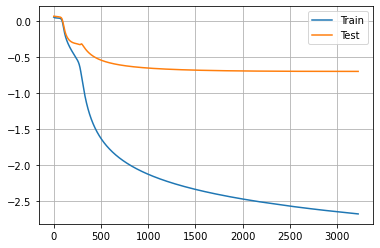

In [55]:
fig, ax = plt.subplots()
ax.plot(np.log10(train_losses), label='Train')
ax.plot(np.log10(test_losses), label='Test')
ax.legend()
ax.grid()

In [56]:
def draw_kkl(nx_G, label_map, node_color, pos=None, **kwargs):
    fig, ax = plt.subplots(figsize=(10,10))
    if pos is None:
        pos = nx.spring_layout(nx_G, k=5/np.sqrt(nx_G.number_of_nodes()))

    nx.draw(
        nx_G, pos, with_labels=label_map is not None, 
        labels=label_map, 
        node_color=node_color, 
        ax=ax, **kwargs)

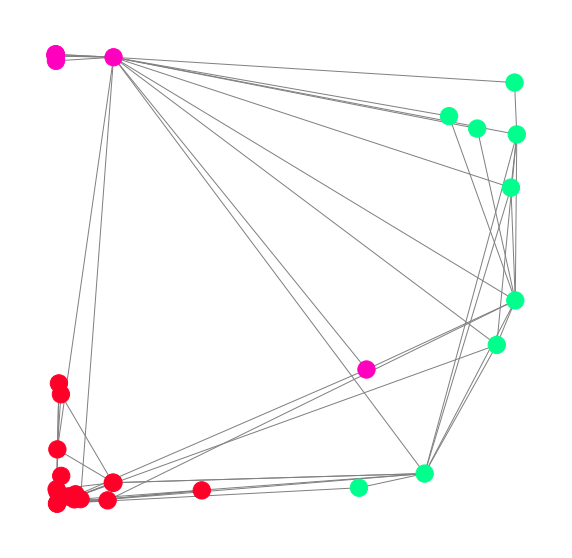

In [57]:
pos = {i: embeds[-1][i,:] for i in range(embeds[-1].shape[0])}
_ = draw_kkl(g, None, colors, pos=pos, cmap='gist_rainbow', edge_color='gray')